In [1]:

"""
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#EXERCICE : ACCELERATION GPU D'UN CNN (basique) CODE EN PYTHON/NUMPY
#
# -> Le but de cet exercice est
#    (1) de bien comprendre comment les parametres d'un reseau de neurones sont appris
#     et en particulier comment fonctionne la backpropagation. L'implementation  python
#    de differentes couches de CNN est donnee. Le CNN apprend alors a reconnaitre des 0
#    et des 1 du jeu de donnees MNIST.
#    (2) rendre le code le plus rapide possible en utilisant de l'acceleration GPU avec
#    openCL ou bien CUDA.
#
#-> Une fois le code compris ... un seul objectif : l'accelerer avec du code GPU !
#
#-> Conseil : Si le temps est limite, focalisez vous sur l'amélioration de
#             'conv_backward', avec au debut un code openCL ou CUDA qui recode
#             l'algorithme sequentiel puis ensuite sa parallelisation. Il sera alors
#             evident de mesurer l'impact de la parallelisation !
#             Une alternative est de se focaliser sur 'dense_forward' qui permet
#             de comparer du code bien optimise avec numpy contre du code GPU. Cette
#             alternative est plus simple a coder mais les gains potentiels sont
#             moindres.
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
"""


import numpy as np
import matplotlib.pyplot as plt
from time import time


In [2]:
#CUDA STUFFS

!pip install pycuda

import pycuda.driver as cuda
from pycuda import driver, compiler, gpuarray, tools 
import pycuda.autoinit


MyDevice=pycuda.driver.Device(0)
MyDevice.get_attributes()

     |████████████████████████████████| 1.6MB 18.1MB/s 
     |████████████████████████████████| 71kB 11.1MB/s 
     |████████████████████████████████| 81kB 12.5MB/s 
  Created wheel for pycuda: filename=pycuda-2020.1-cp36-cp36m-linux_x86_64.whl size=621085 sha256=e977124653bff0e27bebf3aad07411984aed9d91a89ce9c1d4c66c0b622524c9
  Stored in directory: /root/.cache/pip/wheels/8f/78/d1/5bb826f81d9d490297a348d818ff3ee6dd6f2075b06dde6ea0
  Created wheel for pytools: filename=pytools-2020.4.3-py2.py3-none-any.whl size=61374 sha256=266ebc770d5fa2770c8671cb8cbd2df3bc9e0c5d1b14aa4c0bea18f00e931297
  Stored in directory: /root/.cache/pip/wheels/af/c7/81/a22edb90b0b09a880468b2253bb1df8e9f503337ee15432c64
Successfully built pycuda pytools


{pycuda._driver.device_attribute.MAX_THREADS_PER_BLOCK: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_X: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_Y: 1024,
 pycuda._driver.device_attribute.MAX_BLOCK_DIM_Z: 64,
 pycuda._driver.device_attribute.MAX_GRID_DIM_X: 2147483647,
 pycuda._driver.device_attribute.MAX_GRID_DIM_Y: 65535,
 pycuda._driver.device_attribute.MAX_GRID_DIM_Z: 65535,
 pycuda._driver.device_attribute.MAX_SHARED_MEMORY_PER_BLOCK: 49152,
 pycuda._driver.device_attribute.TOTAL_CONSTANT_MEMORY: 65536,
 pycuda._driver.device_attribute.WARP_SIZE: 32,
 pycuda._driver.device_attribute.MAX_PITCH: 2147483647,
 pycuda._driver.device_attribute.MAX_REGISTERS_PER_BLOCK: 65536,
 pycuda._driver.device_attribute.CLOCK_RATE: 1590000,
 pycuda._driver.device_attribute.TEXTURE_ALIGNMENT: 512,
 pycuda._driver.device_attribute.GPU_OVERLAP: 1,
 pycuda._driver.device_attribute.MULTIPROCESSOR_COUNT: 40,
 pycuda._driver.device_attribute.KERNEL_EXEC_TIMEOUT: 0,
 pycuda._driver.device

In [3]:

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                     convolutional layer
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


def init_convolution_filter(size):
  """
  size must be a list of the shape [size_h,size_w]
  """
  w=(0.5+np.random.randn(size[0],size[1]))/(size[0]*size[1])
  return w


def conv_forward(input, w):
    """
    INSPIRED BY: https://gist.github.com/neodelphis
    Remark: here stride=1 / no padding / image has only one layer / only one filter

    A naive implementation of the forward pass for a convolutional layer.
    The input consists of N observations, each of height H and
    width W.
    We convolve each input with a filter of height HH and width WW.
    Input:
    - input: Input data of shape (N, H, W)
    - w: Filter weights of shape (HH, WW)

    Returns a tuple of:
    - output: Output data, of shape (N, H', W') where H' and W' are given by H'=H and W'=W
    - cache: (input, w)
    """

    N, H, W = input.shape
    HH, WW = w.shape

    # dimensions de la sortie (tests sur la validité des choix necessaires ensuite / sinon padding)
    H_ = H
    W_ = W

    output = np.zeros((N, H_, W_))

    # Version sans vectorisation
    for n in range(N):       # On parcourt toutes les images
            for i in range(H_): # indices du résultat
                for j in range(W_):
                    for k in range(HH): # indices du filtre
                        for l in range(WW):
                          if i+k<H and j+l<W:   #test whether we're inside the image
                                output[n,i,j] += input[n, i+k, j+l] * w[k, l]

    cache = (input, w)
    return output, cache



def conv_backward(grad_output, cache):
    """
    INSPIRED BY: https://gist.github.com/neodelphis
    Remark: here stride=1 / no padding / image has only one layer / only one filter

    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - grad_output: Upstream derivatives. -> Gradient of the loss at the output of the layer
    - cache: A tuple of (input, w) as in conv_forward_naive

    Returns a tuple of:
    - grad_input: Gradient of the loss at the input of the layer wrt input
    - grad_w: Gradient of the loss at the input of the layer wrt w
    """

    # Récupération des variables
    input, w = cache

    # Initialisations
    grad_input = np.zeros_like(input)
    grad_w = np.zeros_like(w)

    # Dimensions
    N, H, W = input.shape
    HH, WW = w.shape
    _, H_, W_ = grad_output.shape   #H_ and W_ sould be equal to H and W

    # Version sans vectorisation
    for n in range(N):       # On parcourt toutes les images
            for i in range(HH): # indices du résultat
                for j in range(WW):
                    for k in range(H_): # indices du filtre
                        for l in range(W_):
                          if i+k<H_ and j+l<W_:
                                grad_w[i,j] += input[n, i+k, j+l] * grad_output[n, k, l]


    # Version sans vectorisation
    for n in range(N):       # On parcourt toutes les images
            for i in range(H): # indices de l'entrée participant au résultat
                for j in range(W):
                    for k in range(HH): # indices du filtre
                        for l in range(WW):
                          if i+k<H and j+l<W:
                                grad_input[n,i,j] += grad_output[n, i+k, j+l] * w[HH-k-1,WW-l-1]

    return grad_input, grad_w



In [19]:

kernel_code_tpl = """
__global__ void cpt_grad_w_Kernel(float *input, float *grad_output, float *grad_w)
{
    int i = threadIdx.x;
    int j = threadIdx.y;
    float tmp=0.;
    int k;
    int l;

    for (k=0;k<28-i;k++){
      for (l=0;l<28-j;l++){
        tmp+=input[(i+k)* 28 + (j+l)]*grad_output[k* 28 + l];
      }
    }
    grad_w[j* 5 + i]+=tmp; 
}
__global__ void cpt_grad_w_seq_Kernel(float *input, float *grad_output, float *grad_w)
{
    int bidon = threadIdx.x;
    
    float tmp;
    int i;
    int j;
    int k;
    int l;

    for (i=0;i<5;i++){
      for (j=0;j<5;j++){
        tmp=0.;
        for (k=0;k<28-i;k++){
          for (l=0;l<28-j;l++){
            tmp+=input[(i+k)* 28 + (j+l)]*grad_output[k* 28 + l];
          }
        }
        grad_w[j* 5 + i]+=tmp;
      }
    }
}


__global__ void cpt_grad_input_Kernel(float *grad_output, float *w, float *grad_input)
{
    int i = threadIdx.x;
    int j = threadIdx.y;
    float tmp=0.;
    int k;
    int l;

    for (k=0;k<5;k++){
      for (l=0;l<5;l++){
        if ((i+k<28)&&(j+l<28)){
          tmp+=grad_output[(i+k)* 28 + (j+l)] * w[(5-k-1 )* 5 + (5-l-1)];
        }
      }
    }

    grad_input[j* 28 + i]+=tmp;
}


__global__ void cpt_grad_input_seq_Kernel(float *grad_output, float *w, float *grad_input)
{
    int bidon = threadIdx.x;
    float tmp;
    int i;
    int j;
    int k;
    int l;

    for (i=0;i<28;i++){
      for (j=0;j<28;j++){
        tmp=0.;
        for (k=0;k<5;k++){
          for (l=0;l<5;l++){
            if ((i+k<28)&&(j+l<28)){
              tmp+=grad_output[(i+k)* 28 + (j+l)] * w[(5-k-1 )* 5 + (5-l-1)];
            }
          }
        }
        grad_input[j* 28 + i]+=tmp;
      }
    }
}

"""


kernel_code = kernel_code_tpl

mod = compiler.SourceModule(kernel_code)
cpt_grad_w_gpu = mod.get_function("cpt_grad_w_Kernel")            #parallized version
cpt_grad_input_gpu = mod.get_function("cpt_grad_input_Kernel")  #parallized version

cpt_grad_w_seq_gpu = mod.get_function("cpt_grad_w_seq_Kernel")           #sequential version
cpt_grad_input_seq_gpu = mod.get_function("cpt_grad_input_seq_Kernel")   #sequential version


def conv_backward_GPU(grad_output, cache):
    """
    Same as conv_backward with GPU code 
    """

    # Récupération des variables
    input, w = cache

    # Initialisations
    grad_input = np.zeros_like(input).astype(np.float32)
    grad_w = np.zeros_like(w).astype(np.float32)

    # Dimensions
    N, H, W = input.shape
    HH, WW = w.shape
    _, H_, W_ = grad_output.shape   #H_ and W_ sould be equal to H and W

    # Version GPU
    w_gpu = gpuarray.to_gpu(w)

    grad_w_gpu = gpuarray.to_gpu(grad_w)



    for n in range(N):       # On parcourt toutes les images
            
      input_gpu = gpuarray.to_gpu(input[n,:,:].astype(np.float32))
      grad_output_gpu = gpuarray.to_gpu(grad_output[n,:,:].astype(np.float32))
      grad_input_gpu = gpuarray.to_gpu(grad_input[n,:,:])
            
      cpt_grad_w_gpu(input_gpu, grad_output_gpu, grad_w_gpu , block=(HH,WW,1)) #parallized version
      cpt_grad_input_gpu(grad_output_gpu, w_gpu, grad_input_gpu, block=(H,W,1)) #parallized version
      
      #cpt_grad_w_seq_gpu(input_gpu, grad_output_gpu, grad_w_gpu , block=(1,1,1))     #sequential version
      #cpt_grad_input_seq_gpu(grad_output_gpu, w_gpu, grad_input_gpu, block=(1,1,1))  #sequential version

    grad_w=grad_w_gpu.get()
    grad_input[n,:,:]=grad_input_gpu.get()
    #cuda.memcpy_dtoh(grad_w, grad_w_gpu)
    #cuda.memcpy_dtoh(grad_input[n,:,:], grad_input_gpu)

    return grad_input, grad_w



In [7]:

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                     dense layer
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def init_dense_layer_weights(input_size, output_size):
  """
  INSPIRED BY:  https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

  initialize the weights of a dense layer
  """
  weights = np.random.normal(loc=0.0,scale = np.sqrt(2/(input_size+output_size)),
                                        size = (input_size,output_size))
  return weights

def dense_forward(input,weights):
  """
  INSPIRED BY:  https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

  forward phase of a dense layer
  """
  cache = (input,weights)
  output = np.dot(input,weights)

  return output, cache

def dense_backward(grad_output,cache):
  """
  INSPIRED BY:  https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

  backward phase of a dense layer. The cache was returned by dense_forward.
  """
  input,weights = cache

  grad_input = np.dot(grad_output, weights.T)

  grad_weights = np.dot(input.T, grad_output)

  return grad_input , grad_weights



In [8]:

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                     ReLU layer
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def ReLU_forward(input):
  """
  INSPIRED BY:  https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9
  """

  cache = (input)
  output = np.maximum(0,input)
  return output , cache

def ReLU_backward(grad_output,cache):
  """
  INSPIRED BY:  https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9
  """

  input = cache
  relu_grad = input > 0
  grad_input=grad_output*relu_grad

  return grad_input



In [9]:

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                     logistic function
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def Logistic_function(input):
  return 1 / (1 + np.exp(-input))

def derivative_Logistic_function(input):
  lf_input=Logistic_function(input)
  return lf_input*(1-lf_input)



In [17]:

#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#                     MAIN
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#1) INIT

#get and treat data
data=np.genfromtxt('./mnist_0_1.csv',delimiter=',')

n_tot=data.shape[0]
p=data.shape[1]

y_train=data[:int(2.*n_tot/3.),0].reshape(-1,1)
X_train=(data[:int(2.*n_tot/3.),1:]/(255.*p)).reshape(-1,28,28)

y_test=data[int(2.*n_tot/3.):,0].reshape(-1,1)
X_test=(data[int(2.*n_tot/3.):,1:]/(255.*p)).reshape(-1,28,28)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)




def ShowMNISTObservation(X_data,y_data,obsNb=0):
  plt.clf()
  plt.imshow(X_data[obsNb,:].reshape((28,28)))
  plt.title('Observation '+str(obsNb)+': Label '+str((y_data[obsNb,0])))
  plt.show()



#ShowMNISTObservation(X_train,y_train,0)
#ShowMNISTObservation(X_train,y_train,1)
#...
#ShowMNISTObservation(X_test,y_train,1)



(2000, 28, 28)
(2000, 1)
(1000, 28, 28)
(1000, 1)


In [21]:

#2) TRAINING
#generate the network parameters
w_conv=init_convolution_filter([5,5])
w_dense=init_dense_layer_weights(28*28, 1)

w_conv_init=w_conv.copy()
w_dense_init=w_dense.copy()

#Stochastic gradient Descent
Batch_size=100
nb_epochs=2

n=X_train.shape[0]

total_time_in_conv_backward=0.
start_time= time()

for epoch in range(nb_epochs):
    print('epoch:',epoch)
    obsIDs=np.arange(n)
    np.random.shuffle(obsIDs)
    batch_start=0

    while batch_start+Batch_size<n:
      x_batch=X_train[obsIDs[batch_start:batch_start+Batch_size],:,:]
      y_true_batch=y_train[obsIDs[batch_start:batch_start+Batch_size],:]

      #forward phase
      output_1 , cache_1 = conv_forward(x_batch, w_conv)
      output_2 , cache_2 = ReLU_forward(output_1)
      output_3 , cache_3 = dense_forward(output_2.reshape(-1,28*28),w_dense) #the reshape is used to flatten the image
      y_pred = Logistic_function(output_3)

      MSE_loss = np.mean( np.power(y_pred-y_true_batch,2.) ) #log-likelihood would be slightly more general

      #backward phase
      grad_MSE_loss = 2*(y_pred-y_true_batch)
      grad_output_3=grad_MSE_loss*derivative_Logistic_function(output_3)
      grad_output_2 , grad_w_dense = dense_backward(grad_output_3,cache_3)
      grad_output_1=ReLU_backward(grad_output_2.reshape(-1,28,28),cache_2)  #the reshape reverts the flattening
      rtime = time()
      grad_input, grad_w_conv=conv_backward_GPU(grad_output_1, cache_1)
      rtime = time() - rtime
      total_time_in_conv_backward+=rtime

      #gradient descent-update
      w_dense-=500*grad_w_dense
      w_conv-=0.001*grad_w_conv    #REMARK: the learning rate has to be much smaller on the convolutional layer than on the dense layer (the data should be re-scaled in this layer to avoid this)

      #prepare the next mini-batch
      batch_start+=Batch_size

      print(MSE_loss)

print('Total time:',time() - start_time)
print('Time in conv_backward:',total_time_in_conv_backward)



epoch: 0
0.2499943200358273
0.23418587876412902
0.22705890453843
0.1944550206550416
0.17593032795043528
0.13782910609170096
0.12646558656732065
0.0872772200827034
0.06878458295342642
0.05919951593389326
0.042453062008353824
0.035423565803161264
0.027622207152667878
0.035432450615660735
0.02969275088586318
0.020466740283250115
0.01830529643995694
0.019450719698541126
0.01659497791802978
epoch: 1
0.01658127277789156
0.03323726777775547
0.009555964731716908
0.011561660675481714
0.007361290795198185
0.008405421034139578
0.013105261017550994
0.008332169899911231
0.00780667947480719
0.017971225089736566
0.01519585914013818
0.008578617303488155
0.007157340890007351
0.013202040542471179
0.010093862151075626
0.007028244376023068
0.007277049962509503
0.0054762689277355545
0.007316551928472683
Total time: 58.05203366279602
Time in conv_backward: 1.2494361400604248


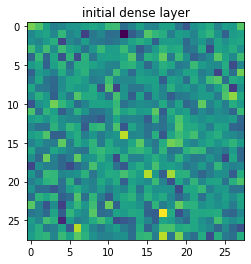

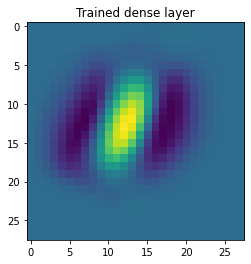

Initial convolution filter:
 [[-0.02273159  0.10871395  0.04852223  0.00701996 -0.00116895]
 [ 0.02643704  0.06256419 -0.00531739 -0.04753842 -0.01567197]
 [ 0.01455576 -0.00567813  0.06549621  0.00756833  0.10406421]
 [ 0.03018358  0.00247295 -0.05895859  0.0936784   0.07112024]
 [ 0.07442261 -0.00549804 -0.00430565  0.03908149 -0.00604087]]
Trained convolution filter:
 [[0.01743605 0.16539711 0.11983128 0.08850567 0.08485553]
 [0.1116793  0.16340819 0.10546907 0.06626086 0.09407391]
 [0.12501003 0.11443922 0.18816987 0.12522031 0.20985887]
 [0.13768675 0.11179591 0.04539873 0.18652348 0.14732518]
 [0.15250721 0.06696026 0.05754672 0.08622854 0.02423194]]
Percentage of good predictions: 99.1


In [20]:

#3) TEST

#show the trained information

plt.imshow(w_dense_init.reshape((28,28)))
plt.title('initial dense layer')
plt.show()

plt.imshow(w_dense.reshape((28,28)))
plt.title('Trained dense layer')
plt.show()

print('Initial convolution filter:\n',w_conv_init)
print('Trained convolution filter:\n',w_conv)


#predictions on test data

output_1 , cache_1 = conv_forward(X_test, w_conv)
output_2 , cache_2 = ReLU_forward(output_1)
output_3 , cache_3 = dense_forward(output_2.reshape(-1,28*28),w_dense)
y_pred = Logistic_function(output_3)

MSE_loss = np.mean( np.power(y_pred-y_test,2.) )

Nb_false_pred=np.sum(np.abs(1*(y_pred>0.5)-y_test))

prct_false_pred=100.*Nb_false_pred/y_test.shape[0]

print('Percentage of good predictions:',100-prct_false_pred)
